# Analyzing data for all vessels in a specific vessel class

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [1]:
pip install signal-ocean

In [2]:
signal_ocean_api_key = '' #replace with your subscription key

## Example 1: Number of spot and number of relet vessels over time
In thi example a supply trend is generated in order to detect the number of spot and relet vessels which open in specific areas.
In this example a date period of 5 days is explored but this can go up until the date of first subscription into TSOP.

In [3]:
from datetime import date, timedelta,time, datetime
from signal_ocean import PortAPI, VesselClassAPI,PortFilter,VesselClassFilter,Connection
from signal_ocean.historical_tonnage_list import VesselFilter, PushType, MarketDeployment, CommercialStatus, VesselSubclass, OperationalStatus
from signal_ocean.historical_tonnage_list import HistoricalTonnageListAPI
from signal_ocean.historical_tonnage_list import IndexLevel

connection = Connection(signal_ocean_api_key)

port_api = PortAPI(connection)
vessel_class_api = VesselClassAPI(connection)
htl_api = HistoricalTonnageListAPI(connection)
vessel_class = vessel_class_api.get_vessel_classes(VesselClassFilter(name_like='aframax'))[0]
port = port_api.get_ports(PortFilter(name_like='ceyhan'))[0]
laycanEndInDays = 512
start_date = datetime.utcnow().date()- timedelta(days=5)
end_date = datetime.utcnow().date()

vessel_filter = VesselFilter(
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5
)


htl_for_supply_trend = htl_api.get_historical_tonnage_list(
    port,
    vessel_class,
    laycanEndInDays,
    start_date,
    end_date,
    vessel_filter=vessel_filter,
    time=time(hour=6)
)

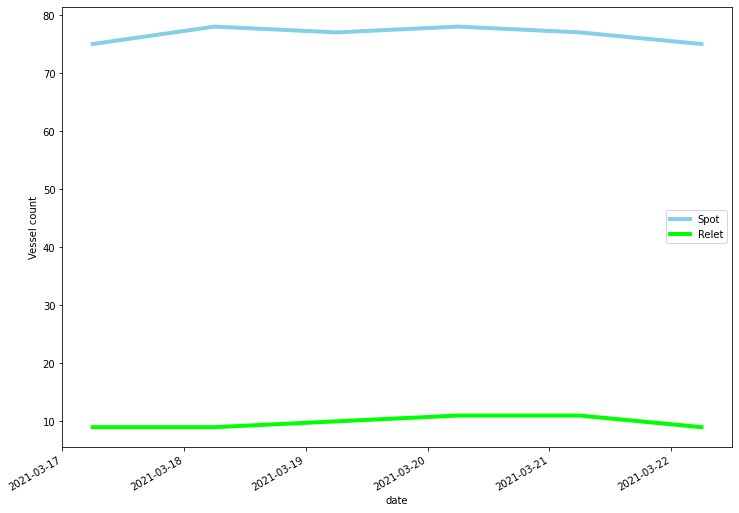

In [4]:
supply_trend_data_frame = htl_for_supply_trend.to_data_frame()
open_areas_of_interest = ['Iberian Atlantic Coast', 'British Isles','North Sea', 'Baltic Sea Low', 'Baltic Sea Upper', 'Continent']
areas_filter = supply_trend_data_frame.open_narrow_area_point_in_time.isin(open_areas_of_interest)
spot_filter = supply_trend_data_frame.market_deployment_point_in_time == 'Spot'
relet_filter = supply_trend_data_frame.market_deployment_point_in_time == 'Relet'
spot_vessels = supply_trend_data_frame[spot_filter & areas_filter].groupby(IndexLevel.DATE, sort=True).size()
relet_vessels = supply_trend_data_frame[relet_filter & areas_filter].groupby(IndexLevel.DATE, sort=True).size()



ax = spot_vessels.plot(markerfacecolor='blue', color='skyblue', linewidth=4, label='Spot', figsize=(12, 9))
ax2 = relet_vessels.plot(ax=ax, markerfacecolor='darkgreen', color='lime',linewidth=4, label='Relet', figsize=(12, 9))

ax2.set_ylabel('Vessel count')
ax2.legend()


## Example2: Number of ballast unfixed vessels in Mediterranean and Black Sea 

In this example, the same data collected from the 1st call will be used, to detect ballast unfixed vessels in Mediterranean and Black Sea areas.

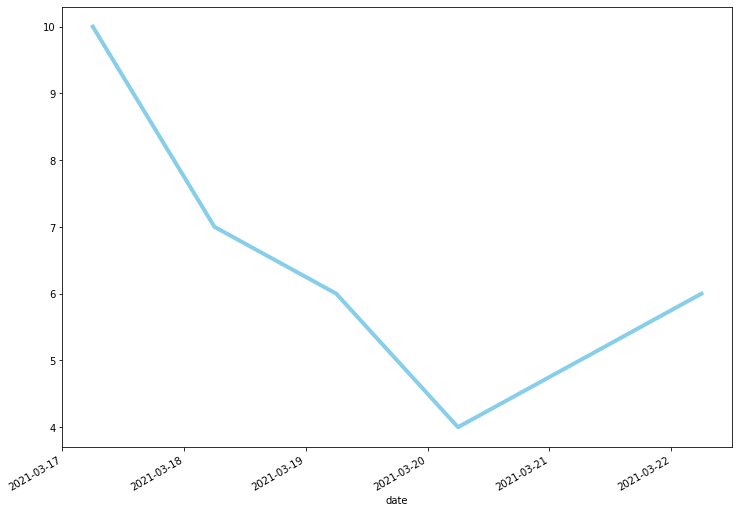

In [5]:
supply_trend_data_frame = htl_for_supply_trend.to_data_frame()
open_areas_of_interest = ['East Mediterranean', 'Central Mediterranean','West Mediterranean', 'Black Sea']

operationalStatuses = [OperationalStatus.BALLAST_UNFIXED]
areas_filter = supply_trend_data_frame.open_narrow_area_point_in_time.isin(open_areas_of_interest)
operational_status_filter = supply_trend_data_frame.operational_status_point_in_time.isin(operationalStatuses)

aggregatedData = supply_trend_data_frame[operational_status_filter & areas_filter].groupby(IndexLevel.DATE, sort=True).size()


ax = aggregatedData.plot(markerfacecolor='blue', color='skyblue', linewidth=4, label='Spot', figsize=(12, 9))

ax2.set_ylabel('Vessel count')
ax2.legend()